In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import openmatrix as omx
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("default")

In [3]:
data_path = Path("../data")
with omx.open_file(data_path / "skims.omx") as skims:
    dists = pd.DataFrame(skims["CAR_DIST__OP"])
    dists.columns = dists.columns + 1
    dists.index = dists.index + 1

In [4]:
asim_path = Path("../output")
asim_results = pd.read_csv(asim_path.joinpath("final_longdist_tours.csv"))  # tours
asim_persons = pd.read_csv(asim_path.joinpath("final_persons.csv"))
asim_hh = pd.read_csv(asim_path.joinpath("final_households.csv"))

In [5]:
oldpath = Path("../legacy-output")
old_results = pd.read_csv(oldpath / "zzLDTPersonTours.csv.gz")  # tours
old_persons = pd.read_csv(oldpath / "zzPersonData.csv.gz")
old_hh = pd.read_csv(oldpath / "zzHouseholdData.csv.gz")

In [6]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = "bottom"

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = "top"

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,  # Use `label` as label
            (x_value, y_value),  # Place label at end of the bar
            xytext=(0, space),  # Vertically shift label by `space`
            textcoords="offset points",  # Interpret `xytext` as offset in points
            ha="center",  # Horizontally center label
            va=va,
        )  # Vertically align label differently for
        # positive and negative values.

# Amount of Unique Households going on Individual Trips

In [7]:
print(asim_results[asim_results.tour_type != "longdist_household"].shape)
print(
    asim_results[asim_results.tour_type != "longdist_household"]
    .household_id.unique()
    .shape
)

(39465, 25)
(38535,)


In [8]:
print(old_results[old_results.tourPurpose != "HOUSEHOLD"].shape)
print(old_results[old_results.tourPurpose != "HOUSEHOLD"].hhID.unique().shape)

(83024, 18)
(62328,)


# Tour Generation Comparison

In [9]:
income_bins = [-np.inf, 20_000, 40_000, 60_000, 90_000, np.inf]
old_hh["HHINC5"] = pd.cut(old_hh.HINC, income_bins)
asim_hh["HHINC5"] = pd.cut(asim_hh.INCOME, income_bins)
pd.concat(
    [
        old_hh.HHINC5.value_counts().rename("Java"),
        asim_hh.HHINC5.value_counts().rename("ASim"),
    ],
    axis=1,
).sort_index().style.set_caption("Total Households by Income").format(
    "{:,}"
).background_gradient()

,Java,ASim
"(-inf, 20000.0]","389,437","206,999"
"(20000.0, 40000.0]","429,206","227,015"
"(40000.0, 60000.0]","337,662","179,829"
"(60000.0, 90000.0]","360,701","191,889"
"(90000.0, inf]","364,044","194,268"


In [10]:
title = "HH LDT Rates by Income"
hh_ldt_rates = (
    pd.concat(
        [
            old_hh.pivot_table(
                values="LD_HOUSEHOLD_TOUR",
                index="HHINC5",
            ).set_axis(["Java"], axis=1),
            asim_hh.pivot_table(
                values="ldt_tour_gen_household",
                index="HHINC5",
            ).set_axis(["ASim"], axis=1),
        ],
        axis=1,
    )
    * 100
)
hh_ldt_rates.style.background_gradient(vmin=0).set_caption(title)

,Java,ASim
HHINC5,,
"(-inf, 20000.0]",0.097577,7.664771
"(20000.0, 40000.0]",0.136764,9.071207
"(40000.0, 60000.0]",0.156369,10.000056
"(60000.0, 90000.0]",0.226226,11.846432
"(90000.0, inf]",0.184868,8.726090


In [11]:
title = "HH LDT Rates by Household Size"
hh_ldt_rates = (
    pd.concat(
        [
            old_hh.pivot_table(
                values="LD_HOUSEHOLD_TOUR",
                index=old_hh.PERSONS.clip(upper=5).rename("N_PERSONS"),
            ).set_axis(["Java"], axis=1),
            asim_hh.pivot_table(
                values="ldt_tour_gen_household",
                index=asim_hh.hhsize.clip(upper=5).rename("N_PERSONS"),
            ).set_axis(["ASim"], axis=1),
        ],
        axis=1,
    )
    * 100
)
hh_ldt_rates.style.background_gradient(vmin=0).set_caption(title)

,Java,ASim
N_PERSONS,,
1,0.156969,10.145101
2,0.234395,12.021560
3,0.106351,6.582944
4,0.074866,6.291665
5,0.073546,6.082362


In [12]:
title = "Relative Change in HH LDT Rates from Java to ASim"
hh_ldt_rates = pd.concat(
    [
        old_hh.pivot_table(
            values="LD_HOUSEHOLD_TOUR",
            index="HHINC5",
            columns=old_hh.PERSONS.clip(upper=5).rename("N_PERSONS"),
        )
        .unstack()
        .rename("Java"),
        asim_hh.pivot_table(
            values="ldt_tour_gen_household",
            index="HHINC5",
            columns=asim_hh.hhsize.clip(upper=5).rename("N_PERSONS"),
        )
        .unstack()
        .rename("ASim"),
    ],
    axis=1,
)
figure = (
    hh_ldt_rates.eval("ASim/Java")
    .unstack()
    .style.background_gradient(axis=None)
    .set_caption(title)
)
figure

HHINC5,"(-inf, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 90000.0]","(90000.0, inf]"
N_PERSONS,,,,,
1,80.687211,65.104058,55.287827,53.622921,46.766862
2,68.271119,58.397396,60.563909,44.580208,43.494647
3,87.369266,104.802441,74.482157,57.048929,43.715214
4,125.923300,97.724509,131.566765,88.491978,60.791461
5,76.048605,141.018774,88.625196,86.047395,65.026152


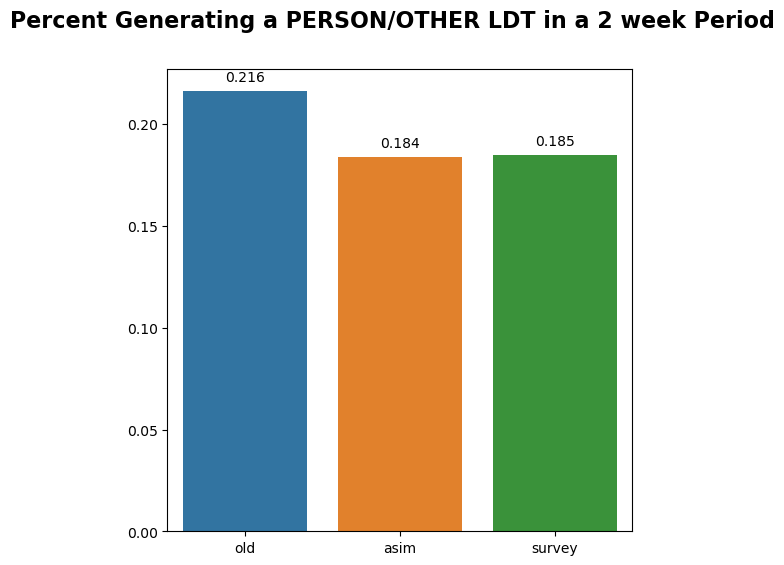

In [13]:
# proportion of people that had generated other trips
old = len(old_persons[(old_persons.LD_INDICATOR_OTHER == 1)]) / len(old_persons)
asim = len(asim_persons[asim_persons.ldt_tour_gen_person_OTHER]) / len(asim_persons)
fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(x=["old", "asim", "survey"], y=[old, asim, 0.185])
fig.suptitle("Percent Generating a PERSON/OTHER LDT in a 2 week Period", fontsize=16, fontweight="bold")
add_value_labels(ax);

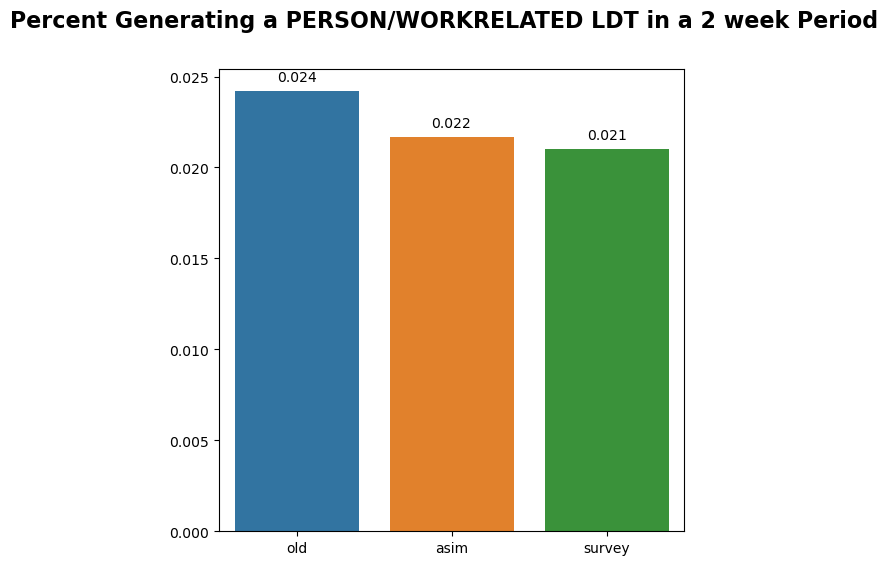

In [14]:
# proportion of people that had generated workrealted trips
old = len(old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)]) / len(old_persons)
asim = len(asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED]) / len(
    asim_persons
)
fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(x=["old", "asim", "survey"], y=[old, asim, 0.021])
fig.suptitle("Percent Generating a PERSON/WORKRELATED LDT in a 2 week Period", fontsize=16, fontweight="bold")
add_value_labels(ax)

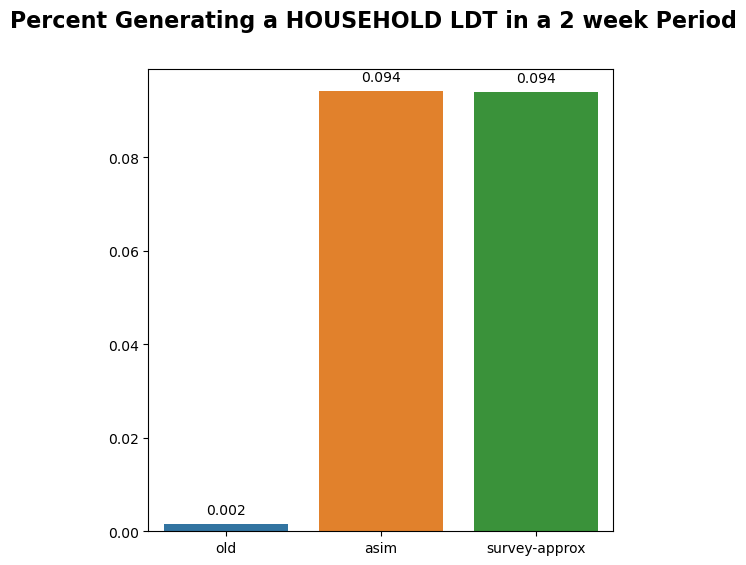

In [15]:
# proportion of households that had generated household trips
old = len(old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]) / len(old_hh)
asim = len(asim_hh[asim_hh.ldt_tour_gen_household]) / len(asim_hh)
fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(x=["old", "asim", "survey-approx"], y=[old, asim, 0.094])
fig.suptitle("Percent Generating a HOUSEHOLD LDT in a 2 week Period", fontsize=16, fontweight="bold")
add_value_labels(ax)
# survey target is percent of persons participating in household LDT, not percent of households.

Asim seems ot significantly undergenerate workrelated LDT trips and overgenerates household LDT trips

In [16]:
# distribution of generated tour types in asim
asim_results["tour_type"].value_counts()

longdist_person_OTHER          31640
longdist_person_WORKRELATED     7825
longdist_household              6637
Name: tour_type, dtype: int64

In [17]:
# distribution of generated tour types in old model
old_results["tourPurpose"].value_counts()

OTHER          69016
WORKRELATED    14008
HOUSEHOLD        518
Name: tourPurpose, dtype: int64

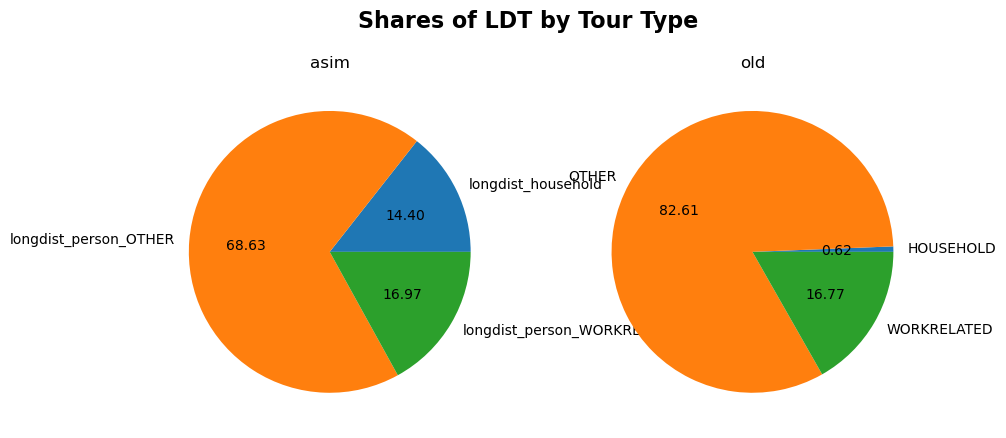

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = asim_results["tour_type"].value_counts().sort_index()
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = old_results["tourPurpose"].value_counts().sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f");
fig.suptitle("Shares of LDT by Tour Type", fontsize=16, fontweight="bold");

# comparison of ldt pattern

## household patterns
(for households that were generated tours)

In [19]:
asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"].value_counts().rename(
    index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}
)

no tour     80147
away         7342
complete     2400
begin        2229
end          2008
Name: ldt_pattern_household, dtype: int64

In [20]:
old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"].value_counts().rename(
    index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"}
)

no tour     2346
away         404
begin        136
complete      92
end            6
Name: LD_HOUSEHOLD_PATTERN, dtype: int64

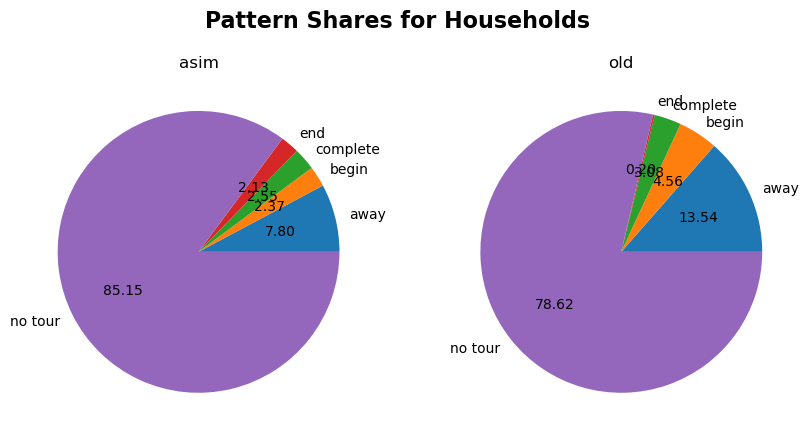

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"]
    .value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .sort_index()
)
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
temp = (
    old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"]
    .value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle("Pattern Shares for Households", fontsize=16, fontweight="bold");

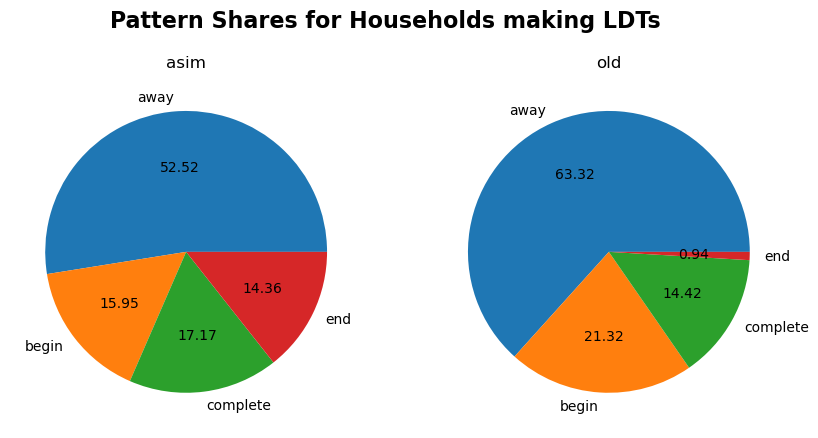

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"]
    .value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .drop("no tour")
    .sort_index()
)
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = (
    old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"]
    .value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .drop("no tour")
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle("Pattern Shares for Households making LDTs", fontsize=16, fontweight="bold");

- For some reason, the distribution of household patterns vary between asim/old, despite the model being frequency based
- The ActivitySim results match the prescribed distribution in the published paper, while the old results do not. 
- The old results suggest there are 21 HH LDtours that leave home for a multiday tour for every 1 such tour that returns home. (!)

## person/workrelated patterns

In [23]:
# enforcing pattern hierarchy
old_persons["ldt_pattern"] = np.where(
    old_persons["LD_INDICATOR_WORKRELATED"] == 1,
    old_persons["LD_TOUR_PATTERN_WORKRELATED"],
    old_persons["LD_TOUR_PATTERN_OTHER"],
)

In [24]:
# this ordering is probably right
old_persons[
    (old_persons.LD_INDICATOR_WORKRELATED == 1)
].ldt_pattern.value_counts().rename(
    index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"}
)

no tour     85231
away        10769
complete     6414
begin        4026
end          3568
Name: ldt_pattern, dtype: int64

In [25]:
asim_persons["ldt_pattern"] = 0

In [26]:
# merging bitshifted patterns
asim_persons["ldt_pattern"] = np.where(
    asim_persons["ldt_pattern_person"].isin([8, 16]), 0, asim_persons["ldt_pattern"]
)
asim_persons["ldt_pattern"] = np.where(
    asim_persons["ldt_pattern_person"].isin([9, 17]), 1, asim_persons["ldt_pattern"]
)
asim_persons["ldt_pattern"] = np.where(
    asim_persons["ldt_pattern_person"].isin([10, 18]), 2, asim_persons["ldt_pattern"]
)
asim_persons["ldt_pattern"] = np.where(
    asim_persons["ldt_pattern_person"].isin([11, 19]), 3, asim_persons["ldt_pattern"]
)
asim_persons["ldt_pattern"] = np.where(
    asim_persons["ldt_pattern_person"].isin([12, 20]), 4, asim_persons["ldt_pattern"]
)

In [27]:
asim_persons[
    asim_persons.ldt_tour_gen_person_WORKRELATED
].ldt_pattern.value_counts().rename(
    index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}
)

no tour     37734
away         6307
complete     3921
begin        2525
end          1946
Name: ldt_pattern, dtype: int64

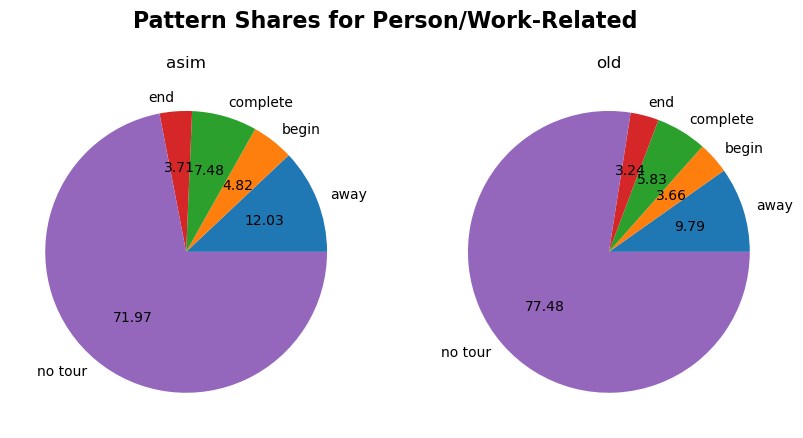

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED]
    .ldt_pattern.value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .sort_index()
)
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
temp = (
    old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)]
    .ldt_pattern.value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle("Pattern Shares for Person/Work-Related", fontsize=16, fontweight="bold");

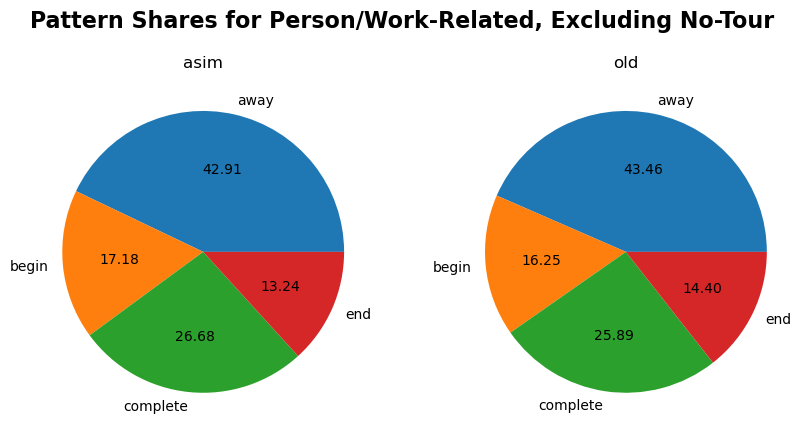

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED]
    .ldt_pattern.value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .drop("no tour")
    .sort_index()
)
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
temp = (
    old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)]
    .ldt_pattern.value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .drop("no tour")
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle(
    "Pattern Shares for Person/Work-Related, Excluding No-Tour",
    fontsize=16,
    fontweight="bold",
);

- proportions still vary slightly for workrelated pattern despite the model being frequency based
- ActivitySim model matches published targets

## person/other patterns

In [30]:
# this ordering is probably right
old_persons[(old_persons.LD_INDICATOR_OTHER == 1)].ldt_pattern.value_counts().rename(
    index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"}
)

no tour     859476
away         52068
complete     41235
begin        16835
end          13485
Name: ldt_pattern, dtype: int64

In [31]:
asim_persons[asim_persons.ldt_tour_gen_person_OTHER].ldt_pattern.value_counts().rename(
    index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}
)

no tour     386800
away         24860
complete     19172
begin         7904
end           6247
Name: ldt_pattern, dtype: int64

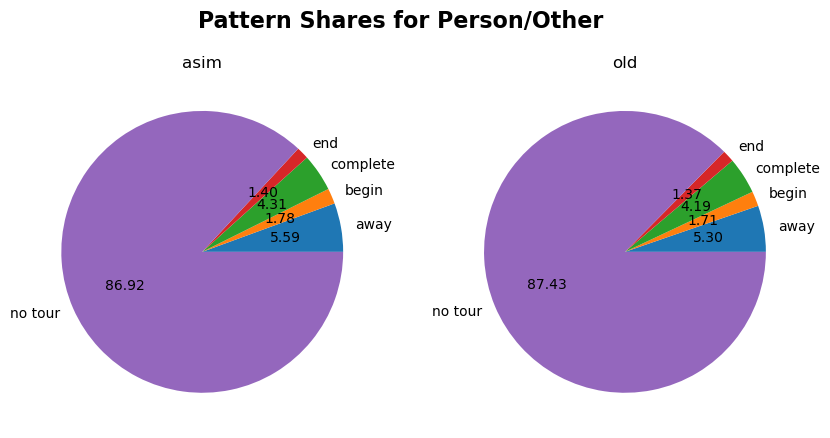

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_persons[asim_persons.ldt_tour_gen_person_OTHER]
    .ldt_pattern.value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .sort_index()
)
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
temp = (
    old_persons[(old_persons.LD_INDICATOR_OTHER == 1)]
    .ldt_pattern.value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle("Pattern Shares for Person/Other", fontsize=16, fontweight="bold");

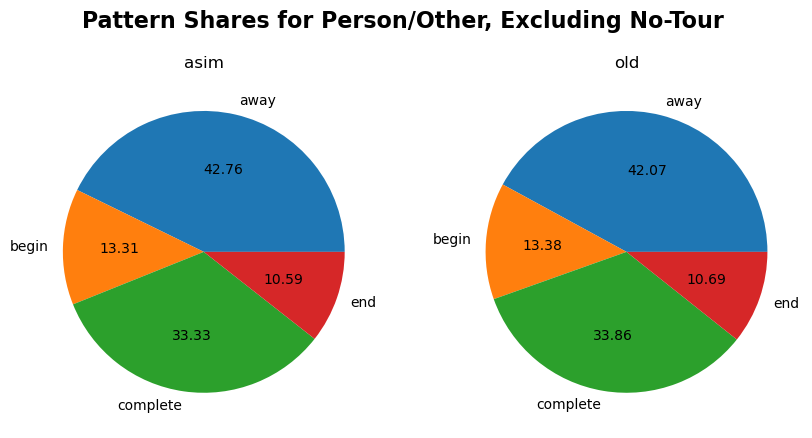

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_persons[
        asim_persons.ldt_tour_gen_person_OTHER
        & ~asim_persons.ldt_tour_gen_person_WORKRELATED
    ]
    .ldt_pattern.value_counts()
    .rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})
    .drop("no tour")
    .sort_index()
)
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
temp = (
    old_persons[
        (old_persons.LD_INDICATOR_OTHER == 1)
        & (old_persons.LD_INDICATOR_WORKRELATED == 0)
    ]
    .ldt_pattern.value_counts()
    .rename(index={0: "complete", 1: "begin", 2: "end", 3: "away", 4: "no tour"})
    .drop("no tour")
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle(
    "Pattern Shares for Person/Other, Excluding No-Tour", fontsize=16, fontweight="bold"
);

generally, asim pattern proportions seem to follow what was defined in java/the specfiication files -- differences from java could be due to downstream propogation of error

# scheduling

In [34]:
# merging bitshifted patterns
asim_results["ldt_pattern"] = np.where(
    asim_results["ldt_pattern"].isin([8, 16]), 0, asim_results["ldt_pattern"]
)
asim_results["ldt_pattern"] = np.where(
    asim_results["ldt_pattern"].isin([9, 17]), 1, asim_results["ldt_pattern"]
)
asim_results["ldt_pattern"] = np.where(
    asim_results["ldt_pattern"].isin([10, 18]), 2, asim_results["ldt_pattern"]
)
asim_results["ldt_pattern"] = np.where(
    asim_results["ldt_pattern"].isin([11, 19]), 3, asim_results["ldt_pattern"]
)
asim_results["ldt_pattern"] = np.where(
    asim_results["ldt_pattern"].isin([12, 20]), 4, asim_results["ldt_pattern"]
)

## start tours

In [35]:
asim_results[asim_results.ldt_pattern == 1].ldt_start_hour.value_counts()

9     1260
8     1172
7     1030
17     983
10     929
18     811
6      775
16     758
12     684
15     673
14     616
13     602
11     454
5      371
19     309
4      234
20     119
21      69
3       58
1       24
2       21
23      18
0        6
22       6
Name: ldt_start_hour, dtype: int64

In [36]:
old_results["start_hour"] = old_results.departureTime / 100

In [37]:
old_results[old_results.patternType == "BEGIN_TOUR"].start_hour.value_counts()

9.0     2506
8.0     2364
10.0    1829
7.0     1817
17.0    1618
15.0    1334
6.0     1216
12.0    1129
18.0    1088
13.0    1034
16.0     917
11.0     727
14.0     712
19.0     557
5.0      517
4.0      399
20.0     159
21.0     106
3.0       92
2.0       48
1.0       35
22.0      21
0.0       19
23.0      18
Name: start_hour, dtype: int64

In [38]:
def compare_hist(asim, java, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    sns.histplot(asim, ax=ax, stat="density", discrete=True, label="asim", linewidth=0)
    sns.histplot(
        java, ax=ax, stat="density", discrete=True, label="old", fill=False, color="k"
    )
    ax.legend()
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold")

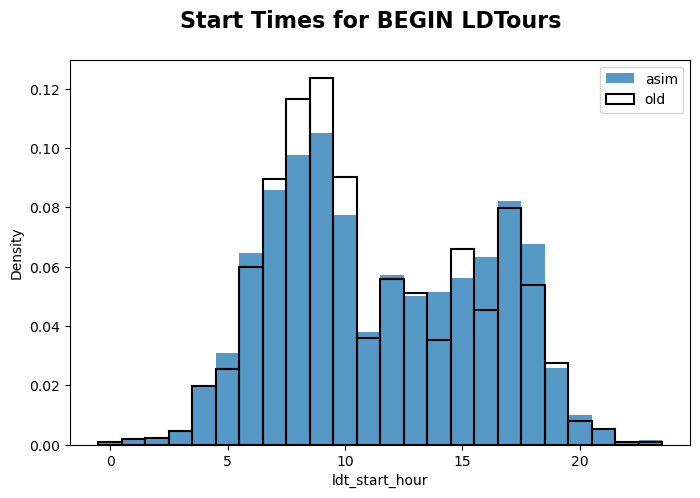

In [39]:
compare_hist(
    asim_results[asim_results.ldt_pattern == 1].ldt_start_hour,
    old_results[old_results.patternType == "BEGIN_TOUR"].start_hour,
    title="Start Times for BEGIN LDTours",
)

begin pattern start hour distribution is roughly identical between old/asim

## end tours

In [40]:
asim_results[asim_results.ldt_pattern == 2].ldt_end_hour.value_counts()

8     1018
7      795
10     753
9      703
17     679
18     641
16     614
6      548
15     541
12     528
14     498
13     450
5      365
11     351
19     293
0      189
20     150
21     141
1      103
2       83
4       75
22      71
23      68
3       47
Name: ldt_end_hour, dtype: int64

In [41]:
old_results["end_hour"] = old_results.arrivalTime / 100
old_results[old_results.patternType == "END_TOUR"].end_hour.value_counts()

8.0     2113
10.0    1390
7.0     1323
9.0     1299
6.0     1109
17.0    1081
15.0    1008
12.0     882
16.0     845
14.0     724
18.0     712
13.0     643
5.0      580
11.0     557
19.0     433
0.0      276
20.0     264
21.0     200
2.0      175
1.0      172
22.0     160
4.0      154
23.0     134
3.0       68
Name: end_hour, dtype: int64

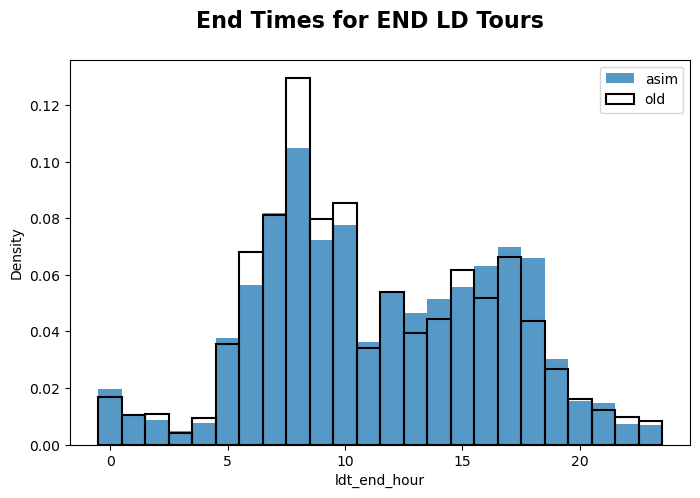

In [42]:
compare_hist(
    asim_results[asim_results.ldt_pattern == 2].ldt_end_hour,
    old_results[old_results.patternType == "END_TOUR"].end_hour,
    title="End Times for END LD Tours",
)

end pattern end hour distribution is roughly identical between old/asim

## complete tours

In [43]:
asim_results[asim_results.ldt_pattern == 3].ldt_start_hour.value_counts()

9     5420
8     4854
7     2206
10    2106
11    1899
12    1528
15    1341
13    1041
6      945
5      937
14     722
16     630
17     571
18     216
Name: ldt_start_hour, dtype: int64

In [44]:
old_results[old_results.patternType == "COMPLETE_TOUR"].start_hour.value_counts()

9.0     10836
8.0     10713
7.0      4570
10.0     3413
11.0     3394
15.0     2322
12.0     2135
13.0     2051
6.0      1744
16.0     1587
5.0      1484
17.0     1223
14.0     1076
18.0      430
Name: start_hour, dtype: int64

In [45]:
asim_results[asim_results.ldt_pattern == 3].ldt_end_hour.value_counts()

20    4229
19    3115
18    3007
17    2838
16    2426
21    1843
15    1834
22    1577
14    1259
13     865
23     606
12     469
11     223
10      87
9       27
8        9
7        2
Name: ldt_end_hour, dtype: int64

In [46]:
old_results[old_results.patternType == "COMPLETE_TOUR"].end_hour.value_counts()

20.0    8224
19.0    5838
17.0    5477
18.0    5200
16.0    5073
15.0    3808
21.0    3263
22.0    2945
14.0    2672
13.0    1661
23.0    1245
12.0     914
11.0     386
10.0     204
9.0       47
8.0       17
7.0        4
Name: end_hour, dtype: int64

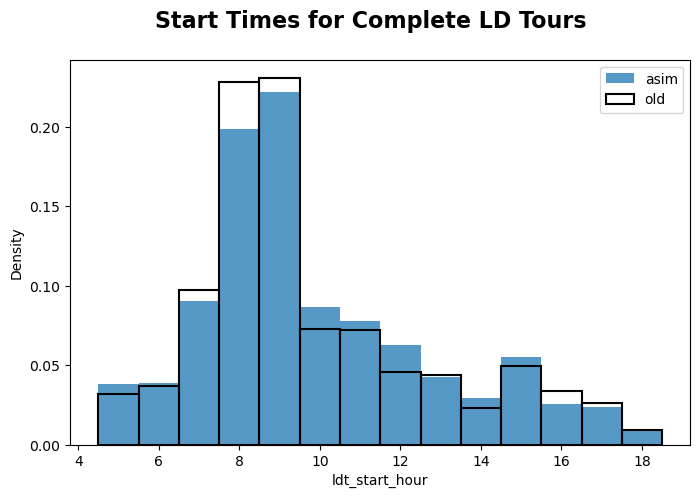

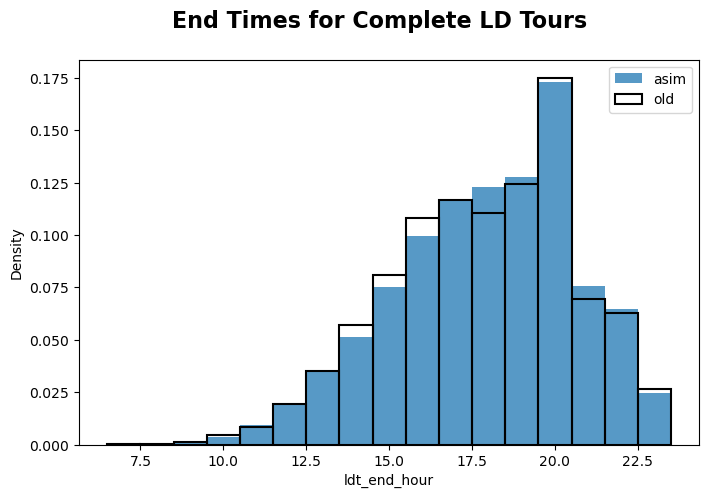

In [47]:
compare_hist(
    asim_results[asim_results.ldt_pattern == 3].ldt_start_hour,
    old_results[old_results.patternType == "COMPLETE_TOUR"].start_hour,
    title="Start Times for Complete LD Tours",
)
compare_hist(
    asim_results[asim_results.ldt_pattern == 3].ldt_end_hour,
    old_results[old_results.patternType == "COMPLETE_TOUR"].end_hour,
    title="End Times for Complete LD Tours",
)

complete tour start/end hour distributions are about the same

In [48]:
asim_results[asim_results.ldt_pattern == 3][["ldt_start_hour", "ldt_end_hour"]]

,ldt_start_hour,ldt_end_hour
1,13,19
2,6,20
5,9,13
16,8,20
21,5,14
...,...,...
46093,6,18
46097,18,21
46099,7,13
46100,5,13


In [49]:
asim_results["duration"] = np.where(
    asim_results.ldt_pattern == 3,
    asim_results["ldt_end_hour"] - asim_results["ldt_start_hour"],
    5,
)

In [50]:
asim_results["duration"].min()

2

In [51]:
asim_results["duration"].max()

18

In [52]:
old_results["duration"] = np.where(
    old_results.patternType == "COMPLETE_TOUR",
    old_results["end_hour"] - old_results["start_hour"],
    5,
)

In [53]:
old_results["duration"].min()

2.0

In [54]:
old_results["duration"].max()

17.0

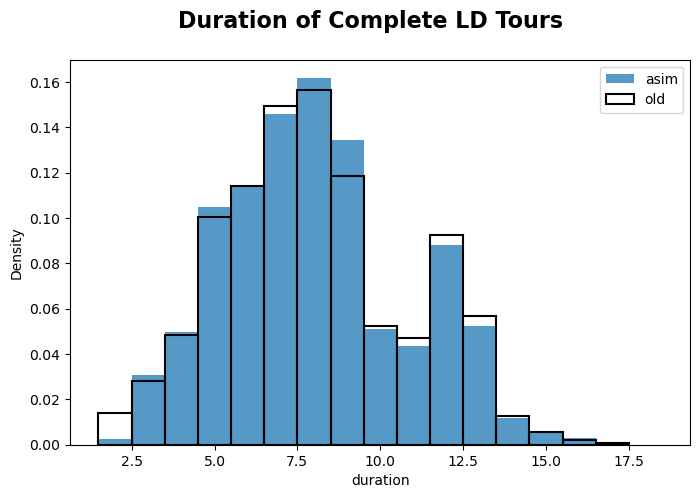

In [55]:
compare_hist(
    asim_results[asim_results.ldt_pattern == 3].duration,
    old_results[old_results.patternType == "COMPLETE_TOUR"].duration,
    title="Duration of Complete LD Tours",
)

complete tour duration distribution seems to be about the same

# internal_external

In [56]:
# 1 external, 0 internal
asim_results.internal_external.value_counts()

0    32344
1    13758
Name: internal_external, dtype: int64

In [57]:
old_results.destinationType.value_counts()

INTERNAL    61167
EXTERNAL    22375
Name: destinationType, dtype: int64

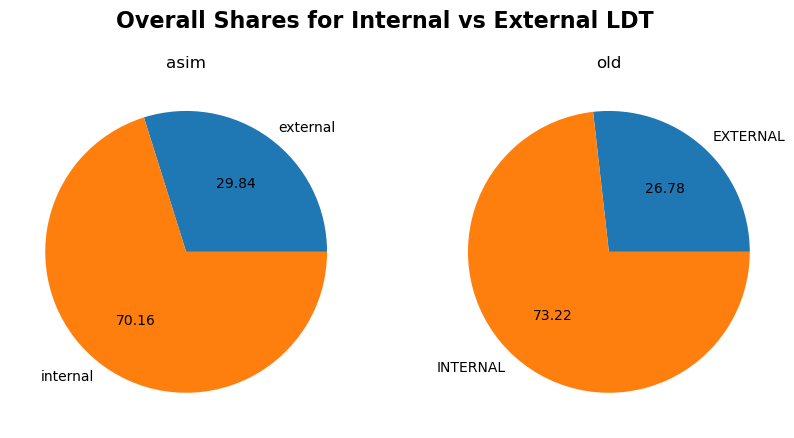

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_results["internal_external"]
    .map(lambda x: "internal" if x == 0 else "external")
    .value_counts()
    .sort_index()
)
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = old_results["destinationType"].value_counts().sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
fig.suptitle("Overall Shares for Internal vs External LDT", fontsize=16, fontweight="bold");

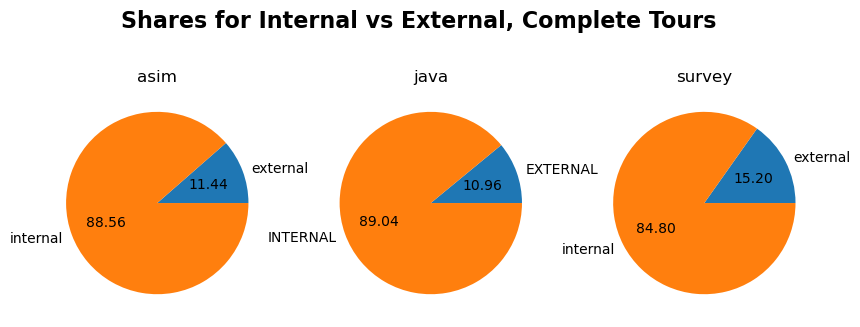

In [59]:
temp = (
    asim_results.query("ldt_pattern == 3")["internal_external"]
    .map(lambda x: "internal" if x == 0 else "external")
    .value_counts()
    .sort_index()
)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = old_results.query("patternType == 'COMPLETE_TOUR'")["destinationType"].value_counts().sort_index()
axs[1].title.set_text("java")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
axs[2].title.set_text("survey")
axs[2].pie([15.2, 84.8], labels=["external", "internal"], autopct="%.2f")
fig.suptitle("Shares for Internal vs External, Complete Tours", fontsize=16, fontweight="bold");

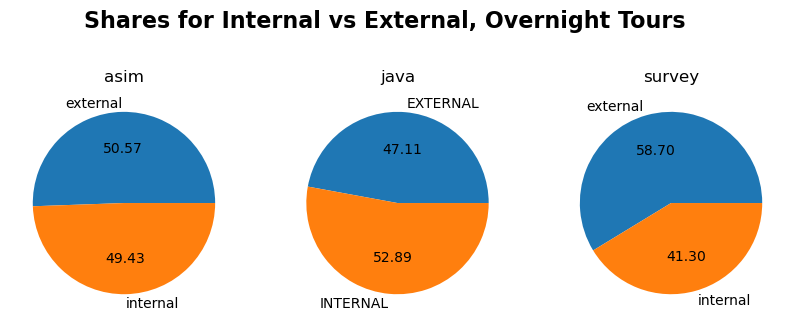

In [60]:
temp = (
    asim_results.query("ldt_pattern != 3")["internal_external"]
    .map(lambda x: "internal" if x == 0 else "external")
    .value_counts()
    .sort_index()
)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = old_results.query("patternType != 'COMPLETE_TOUR'")["destinationType"].value_counts().sort_index()
axs[1].title.set_text("java")
axs[1].pie(temp, labels=temp.index, autopct="%.2f")
axs[2].title.set_text("survey")
axs[2].pie([58.7, 41.3], labels=["external", "internal"], autopct="%.2f")
fig.suptitle("Shares for Internal vs External, Overnight Tours", fontsize=16, fontweight="bold");

internal-external distributions are roughly equal

# external destchoice

In [61]:
import geopandas as gpd
import mapped
shp = gpd.read_file("../data/USA_TAZs_incl_Cube_nx_n.zip").set_index("CUBE_N")
int_shp = shp[shp.MODEL_AREA == 1].copy()
ext_shp = shp[shp.MODEL_AREA == 0].copy()
int_shp.geometry = int_shp.simplify(500)
ext_shp.geometry = ext_shp.simplify(10000)

/Users/jeffnewman/LocalGit/arboretum/larch/larch/model/numbamodel.py:28: UserWarning: 

#### larch v6 is experimental, and not feature-complete ####
the first time you import on a new system, this package will
compile optimized binaries for your specific machine,  which
may take a little while, please be patient ...

  warnings.warn(  # Good news, everyone! This tool might not work. #  )


In [62]:
asim_ext_dest = asim_results[asim_results.internal_external == 1].external_destchoice
print(asim_ext_dest.min(), asim_ext_dest.max())
asim_ext_dest.value_counts()

3726 5102


5076    1017
5061     658
4270     433
3998     396
4503     366
        ... 
4679       1
4224       1
5014       1
4808       1
4293       1
Name: external_destchoice, Length: 267, dtype: int64

In [63]:
_ext_shp = ext_shp.join(asim_ext_dest.value_counts().rename("asim_ext_count"))
_ext_shp.asim_ext_count.fillna(0, inplace=True)
_ext_shp.plotly_choropleth(color="asim_ext_count")

FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'geojson': {'bbox': (-141.00186979144567,…

In [64]:
java_ext_dest = old_results[old_results.destinationType == "EXTERNAL"].destination
print(java_ext_dest.min(), java_ext_dest.max())
java_ext_dest.value_counts()

3726 5102


4292    1719
4503    1422
4270     787
3998     671
4168     610
        ... 
5053       2
3890       2
5014       1
4293       1
5069       1
Name: destination, Length: 271, dtype: int64

In [65]:
_ext_shp = ext_shp.join(java_ext_dest.value_counts().rename("java_ext_count"))
_ext_shp.java_ext_count.fillna(0, inplace=True)
_ext_shp.plotly_choropleth(color="java_ext_count")

FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'geojson': {'bbox': (-141.00186979144567,…

In [66]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
# sns.histplot(
#     asim_results[asim_results.internal_external == 1].external_destchoice,
#     stat="density",
#     ax=axs[0],
#     bins=50,
# )
# axs[0].set_title("asim")
# sns.histplot(
#     old_results[old_results.destinationType == "EXTERNAL"].destination,
#     stat="density",
#     ax=axs[1],
#     bins=50,
# )
# axs[1].set_title("old")

more people seem to be going to other states in asim for external ldts

In [67]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 12))
# sns.histplot(temp_dist, stat="density", ax=axs[0], bins=50)
# axs[0].title.set_text("asim")
# sns.histplot(
#     old_results[old_results.destinationType == "EXTERNAL"].distance,
#     stat="density",
#     ax=axs[1],
#     bins=50,
# )
# axs[1].title.set_text("java model")

In [68]:
def compare_kde(asim, java, title=None, bw_method=0.1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    sns.kdeplot(asim, ax=ax, label="asim", bw_method=bw_method)
    sns.kdeplot(
        java,
        ax=ax,
        label="old",
        bw_method=bw_method,
    )
    ax.legend()
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold")

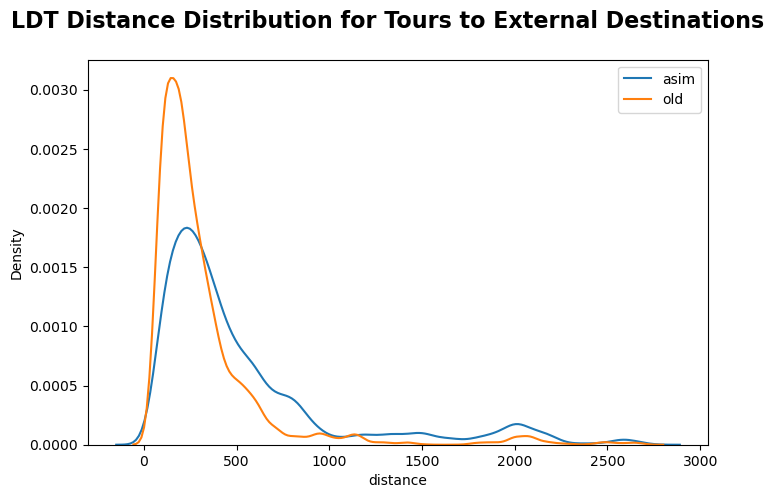

In [69]:
temp = asim_results[asim_results.internal_external == 1]
temp_dist = dists.values[temp.origin, temp.external_destchoice]

compare_kde(
    temp_dist,
    old_results[old_results.destinationType == "EXTERNAL"].distance,
    title="LDT Distance Distribution for Tours to External Destinations",
)

Distance distribution needs assessment

In [70]:
# all external LDTs are basically LDTs (greater than 50 miles away or at least about 50)
dists.values[temp.origin, temp.external_destchoice].min()

7.83

# external mode choice

In [71]:
old_results[old_results.destinationType == "EXTERNAL"].tourMode.value_counts()

AUTO             19123
AIR               3207
TRANSIT_WALK        27
TRANSIT_DRIVE       18
Name: tourMode, dtype: int64

In [72]:
asim_results[asim_results.internal_external == 1].external_tour_mode.value_counts()

DRIVE            11295
AIR               2457
DRIVE_TRANSIT        4
WALK_TRANSIT         2
Name: external_tour_mode, dtype: int64

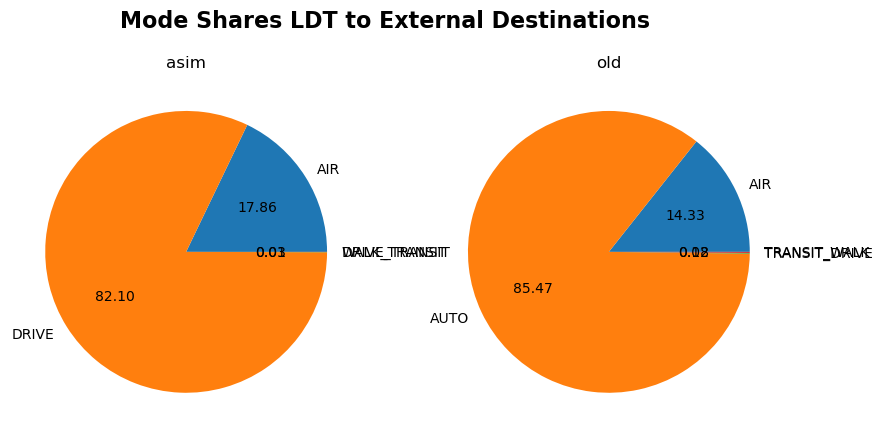

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_results[asim_results.internal_external == 1]
    .external_tour_mode.value_counts()
    .sort_index()
)
axs[0].pie(temp, labels=temp.index, autopct="%.2f")
axs[0].title.set_text("asim")
temp = (
    old_results[old_results.destinationType == "EXTERNAL"]
    .tourMode.value_counts()
    .sort_index()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct="%.2f");
fig.suptitle("Mode Shares LDT to External Destinations", fontsize=16, fontweight="bold");

roughly the same external mode choice distributions, although less air

# internal dest choice

In [74]:
asim_int_dest = asim_results[asim_results.internal_external == 0].internal_destination
asim_int_dest.value_counts()

4877    563
4996    526
4012    457
1070    436
1050    435
       ... 
4928      1
1367      1
454       1
3719      1
2539      1
Name: internal_destination, Length: 2542, dtype: int64

In [75]:
_int_shp = int_shp.join(asim_int_dest.value_counts().rename("asim_int_count"))
_int_shp.asim_int_count.fillna(0, inplace=True)
_int_shp.plotly_choropleth(color="asim_int_count")

FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'geojson': {'bbox': (-85.44882106294868, …

In [76]:
java_int_dest = old_results[old_results.destinationType == "INTERNAL"].destination
java_int_dest.value_counts()

1070    384
1201    339
1016    333
1059    305
1066    243
       ... 
4928      1
2425      1
2475      1
4150      1
3578      1
Name: destination, Length: 3996, dtype: int64

In [77]:
_int_shp = int_shp.join(java_int_dest.value_counts().rename("java_int_count"))
_int_shp.java_int_count.fillna(0, inplace=True)
_int_shp.plotly_choropleth(color="java_int_count")

FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'geojson': {'bbox': (-85.44882106294868, …

In [78]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
# sns.histplot(
#     asim_results[asim_results.internal_external == 0].internal_destination,
#     stat="density",
#     ax=axs[0],
#     bins=50,
# )
# sns.histplot(
#     old_results[old_results.destinationType == "INTERNAL"].destination,
#     stat="density",
#     ax=axs[1],
#     bins=50,
# )

seems ot be a lot more people going to the 4800+ TAZs in asim

In [79]:
lu = pd.read_parquet(data_path / "land_use.parquet").set_index("TAZ")

In [80]:
# all internal trips are indeed internal
# lu.loc[
#     asim_results[asim_results.internal_external == 0]
#     .internal_destination.value_counts()
#     .index
#     + 1
# ]["MODELAREA"].value_counts()

In [81]:
# all external trips are indeed external
# lu.loc[
#     asim_results[asim_results.internal_external == 1]
#     .external_destchoice.value_counts()
#     .index
#     + 1
# ]["MODELAREA"].value_counts()

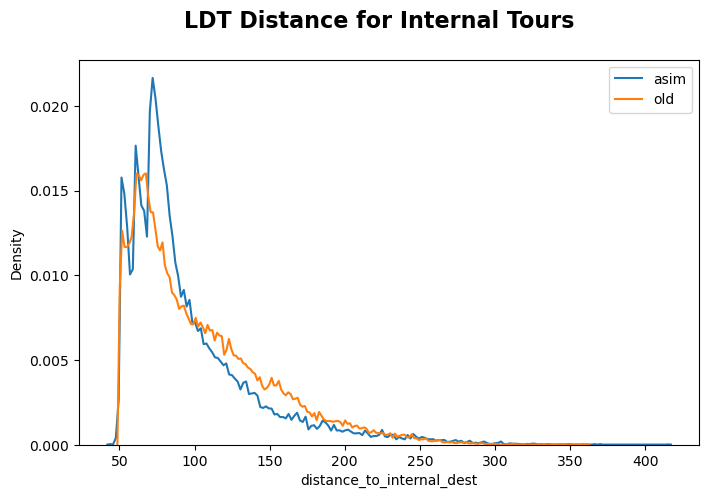

In [82]:
compare_kde(
    asim_results[asim_results.internal_external == 0].distance_to_internal_dest,
    old_results[old_results.destinationType == "INTERNAL"].distance,
    title="LDT Distance for Internal Tours",
    bw_method=0.01,
)

In [83]:
asim_ = {
    name: group.distance_to_internal_dest 
    for name, group in asim_results[asim_results.internal_external == 0].groupby("tour_type")
}
asim_.keys()

dict_keys(['longdist_household', 'longdist_person_OTHER', 'longdist_person_WORKRELATED'])

In [84]:
java_ = {
    name: group.distance
    for name, group in old_results[old_results.destinationType == "INTERNAL"].groupby("tourPurpose")
}
java_.keys()

dict_keys(['HOUSEHOLD', 'OTHER', 'WORKRELATED'])

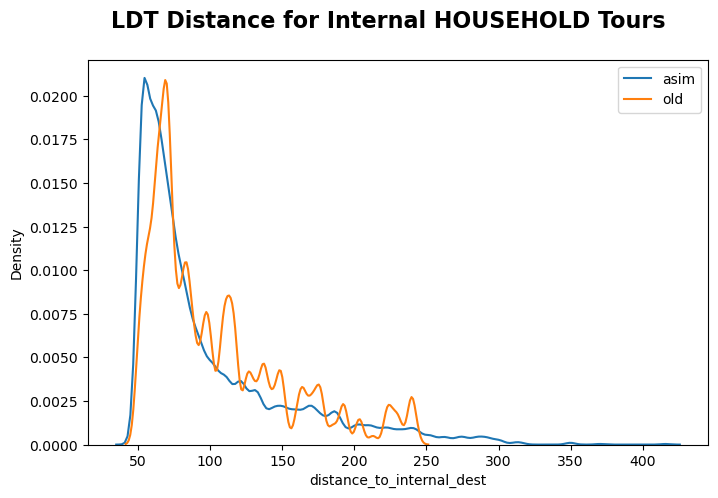

In [85]:
compare_kde(
    asim_['longdist_household'],
    java_['HOUSEHOLD'],
    title="LDT Distance for Internal HOUSEHOLD Tours",
    bw_method=0.06,
)

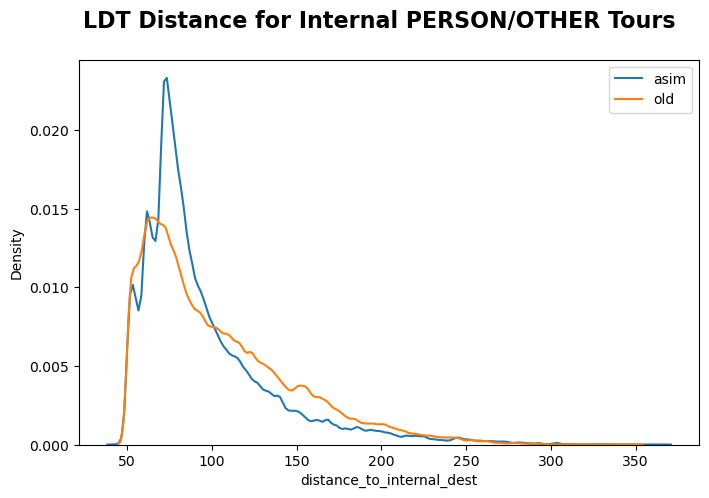

In [86]:
compare_kde(
    asim_['longdist_person_OTHER'],
    java_['OTHER'],
    title="LDT Distance for Internal PERSON/OTHER Tours",
    bw_method=0.04,
)

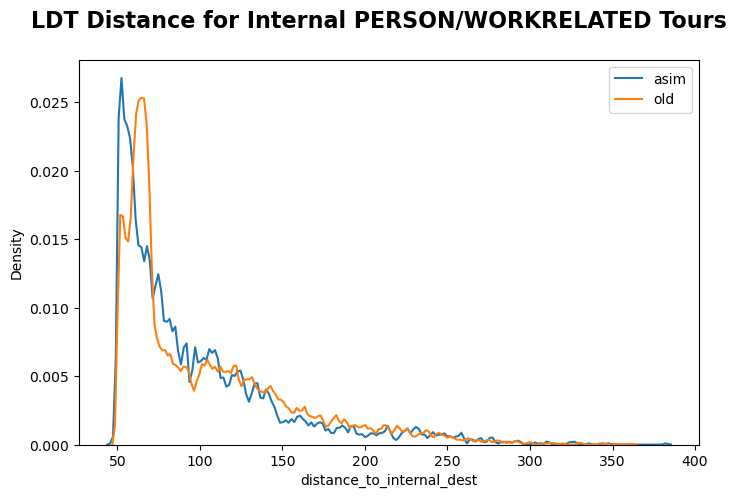

In [87]:
compare_kde(
    asim_['longdist_person_WORKRELATED'],
    java_['WORKRELATED'],
    title="LDT Distance for Internal PERSON/WORKRELATED Tours",
    bw_method=0.02,
)

# internal mode choice

In [88]:
old_results[old_results.destinationType == "INTERNAL"].tourMode.value_counts()

AUTO             60755
AIR                149
TRANSIT_WALK       140
TRANSIT_DRIVE      122
HSR_DRIVE            1
Name: tourMode, dtype: int64

In [89]:
asim_results[asim_results.internal_external == 0].tour_mode.value_counts()

PRIVATEAUTO      32174
DRIVE_TRANSIT      138
DRIVE_HSR           20
WALK_TRANSIT        11
AIR                  1
Name: tour_mode, dtype: int64

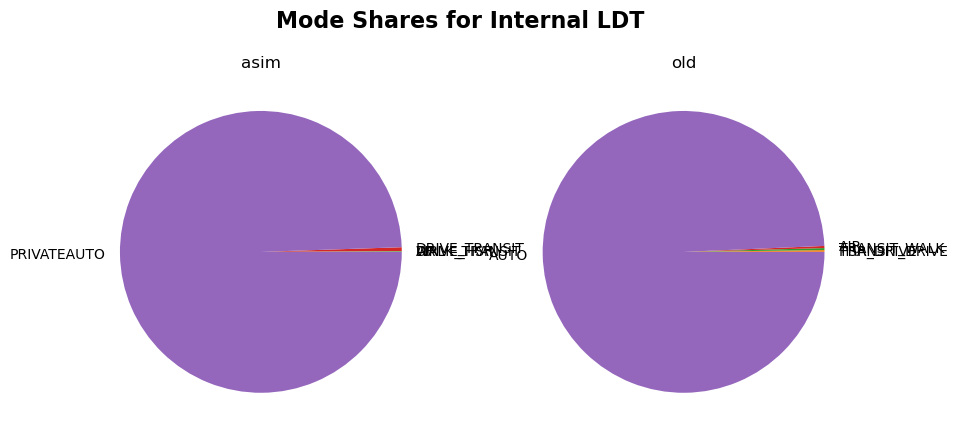

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_results[asim_results.internal_external == 0]
    .tour_mode.value_counts()
    .sort_values()
)
axs[0].pie(temp, labels=temp.index)
axs[0].title.set_text("asim")
temp = (
    old_results[old_results.destinationType == "INTERNAL"]
    .tourMode.value_counts()
    .sort_values()
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index)
fig.suptitle("Mode Shares for Internal LDT", fontsize=16, fontweight="bold");

In [91]:
asim_results[asim_results.internal_external == 0].tour_mode.value_counts()

PRIVATEAUTO      32174
DRIVE_TRANSIT      138
DRIVE_HSR           20
WALK_TRANSIT        11
AIR                  1
Name: tour_mode, dtype: int64

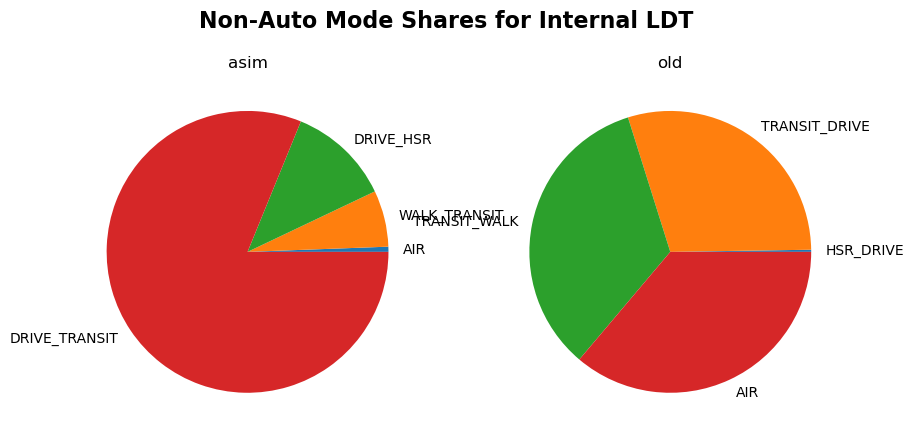

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
temp = (
    asim_results[asim_results.internal_external == 0]
    .tour_mode.value_counts()
    .sort_values()
    .drop("PRIVATEAUTO")
)
axs[0].pie(temp, labels=temp.index)
axs[0].title.set_text("asim")
temp = (
    old_results[old_results.destinationType == "INTERNAL"]
    .tourMode.value_counts()
    .sort_values()
    .drop("AUTO")
)
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index)
fig.suptitle("Non-Auto Mode Shares for Internal LDT", fontsize=16, fontweight="bold");

roughly the same macro-level distribution, but asim curiously doesn't have any air trips \\ 
could be a downstream effect of lower workrelated trips